In [1]:
import argparse
from collections import Counter
import logging
import os

import cv2
import numpy as np
import pandas as pd
import torch

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/repos/mrnet/scripts')
from loader import load_data
from model_choice import MODELS
import cam

diagnosis = 'acl'
series = 'axial'
model_names = ['MRNet', 'MRNet-Squeeze', 'MRNet-Attend', 'MRNet-SqueezeAttend']
model_paths = {
    mn: cam.get_model_path(mn, diagnosis, series) for mn in model_names
}

gpu=False
test_loader = cam.get_data(diagnosis, series, gpu)
vol, label, case = test_loader.dataset[88]

case

'1218.npy'

In [31]:
hists = {}
for mn in model_names:
    n_seq = vol.shape[0]
    model = cam.get_model(mn, model_paths[mn], gpu)
    x = torch.squeeze(vol, dim=0)  # only batch size 1 supported
    features = model.model.features(x)
    x = model.gap(features).view(features.size(0), -1)
    name = model.__class__.__name__
    
    if 'Attention' in name:
        soft = torch.softmax(model.attention(x), dim=0).data.cpu().numpy().ravel()
        print(m.shape)
        draws = np.random.multinomial(soft.size, soft)
        m = np.concatenate([np.array([i] * draws[i]) for i in range(n_seq)]).ravel()
    else:
        m = torch.argmax(x, 0).view(-1).data.cpu().numpy()
        print(m.shape)
    hists[mn] = m

(256,)
(512,)
(512,)
(26,)


In [32]:
for mn in model_names:
    print('{}: {}'.format(mn, hists[mn]))

MRNet: [11 14 23  3 19 19 25 13 11 12 11 20  3 11 23  0 14 11 14 15 11 19  7  6
  3 19 19 19  7 11  9 19 12  0 15  8 24  3  7 23 20 19  6 12 19 23 11 25
 25  7 24 14 14 13 19 25 11 23 14 11 19  6 19  9  8 19  9 20  4 14 17 19
  8  3 14 19  6  7  7 11  4 24  7 23 19 11 14 20  8  6  7 20 14 11 24 14
 17 24 19 11  6  3  7 23  5  9  9 14  7  7  3 25 19 24  6 11  8  4 14  0
  2 11  8 19 11  7  9  4  5  7  8  8 11 11  5 12  8  2 13 19  9  7 19 11
 12 11 12 11  7 19 11  6  7  7 19  8 24  4  4 11  8  8  6  9 11  1 23 11
  2  7 14  9 24 11 11 19  8 14 11 12 15 11 25 18 11 23 11 18 19  7  1 13
 10  4 19 13 11 11 23 24  9 19  4  9 11 11 14 19 23 11  7  7 11  6 11  7
  7 11 13 14 25 19  6 25  8  7  9  6  6  7 19 12 21 19 11 11 19  0 11 12
 14 24  9  8  3 15  4  7 18 23  6 24  5  4  9 14]
MRNet-Squeeze: [11 11 22 25 21 13  4  7 12  8 11 22  3 24 19 13 11  6 18  4 12 24 18 12
 20 11 12  2 24 16  5 11 20  7 24  7 18 22 25 18 20  7  9  6  4 18 11  3
 14 25 12 16 10 10 20  2 13  8 24 14 19 24  2  7  0 

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


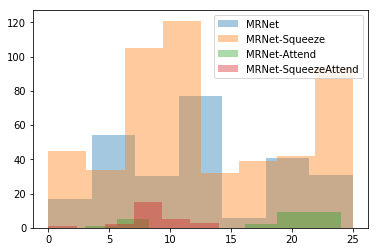

In [29]:
for mn in model_names:
    sns.distplot(hists[mn], label=mn, kde=False)
plt.legend();